## IMPORTAR BIBLIOTECAS

In [1]:
import numpy as np
import pandas as pd
import sys
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
current_dir = Path().resolve()
sys.path.append(str(current_dir.parent))

from config import RAW_DATA_PATH, PROCESSED_DATA_PATH
pd.options.display.max_columns = None

## IMPORTAR DATOS

In [3]:
data = pd.read_csv(PROCESSED_DATA_PATH / 'lendingclub_processed.csv')

C:\Users\SANTY\AppData\Local\Temp\ipykernel_12644\2528382491.py:1: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(PROCESSED_DATA_PATH / 'lendingclub_processed.csv')


In [4]:
data.loan_status.unique()

array(['fully paid', 'charged off', 'current', 'default',
       'late (31-120 days)', 'in grace period', 'late (16-30 days)',
       'does not meet the credit policy. status:fully paid',
       'does not meet the credit policy. status:charged off'],
      dtype=object)

In [5]:
data.loan_status.value_counts()

loan_status
current                                                224226
fully paid                                             184739
charged off                                             42475
late (31-120 days)                                       6900
in grace period                                          3146
does not meet the credit policy. status:fully paid       1988
late (16-30 days)                                        1218
default                                                   832
does not meet the credit policy. status:charged off       761
Name: count, dtype: int64

In [6]:
data['target'] = np.where(data.loan_status.isin([
    'charged Off', 'default', 'does not meet the credit policy. status:charged off'
]), 0, 1)

In [7]:
data.target.value_counts()

target
1    464692
0      1593
Name: count, dtype: int64

## PARTICIÓN DE LOS DATOS

In [8]:
X = data.drop(columns='target')
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, test_size=0.1)

In [9]:
#X_train = X_test
#y_train = y_test

### PESO DE LA EVIDENCIA (PdE) Y VALOR DE LA INFORMACIÓN (VI) - VARIABLES CATEGORICAS

In [10]:
columns = X_train.select_dtypes('object').columns
uniques = {}

for col in columns:
    u = list(X_train[col].unique())
    uniques[col] = len(u)

pd.Series(uniques).sort_values(ascending=False).head(20)

url                    419656
emp_title              188008
desc                   112050
title                   57682
zip_code                  884
earliest_cr_line          662
last_credit_pull_d        104
next_pymnt_d              101
last_pymnt_d               99
issue_d                    91
addr_state                 50
sub_grade                  35
purpose                    14
loan_status                 9
grade                       7
home_ownership              6
verification_status         3
initial_list_status         2
pymnt_plan                  2
application_type            1
dtype: int64

In [11]:
def PdE_categorica(df, var_categorica, df_var_dependiente):
    df = pd.concat([df[var_categorica], df_var_dependiente], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                 df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis=1)
    df = df.iloc[:, [0,1,3]]
    df.columns = [df.columns.values[0], 'observaciones', 'prop_bueno']

    # Calcula el PdE para cada categoria de la variable
    df['proporcion_obs'] = df['observaciones']/df['observaciones'].sum()
    df['n_buenos'] = df['prop_bueno']*df['observaciones']
    df['n_malos'] = (1- df['prop_bueno'])*df['observaciones'] 
    df['prop_n_buenos'] = df['n_buenos']/df['n_buenos'].sum()
    df['prop_n_malos'] = df['n_malos']/df['n_malos'].sum() 
    df['PdE'] = np.log(df['prop_n_buenos']/df['prop_n_malos'])
    df = df.sort_values(['PdE'])
    df = df.reset_index(drop = True)

    # Calcula el VI para cada categoria de la variable
    df['delta_prop_n_buenos'] = df['prop_n_buenos'].diff().abs() 
    df['delta_PdE'] = df['PdE'].diff().abs() #Diferencia Absoluta entre categorías
    df['VI'] = (df['prop_n_buenos'] - df['prop_n_malos']) * df['PdE']
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df['sumatoriaVI'] = df['VI'].sum()
    return df[[var_categorica, 'observaciones', 'proporcion_obs', 'PdE', 'VI', 'sumatoriaVI']]

In [12]:
def grafico_PdE(df):
    x = np.array(df.iloc[:,0].apply(str))
    y = df['PdE']
    plt.figure(figsize = (13,3))
    plt.plot(x, y, marker = 'x', linestyle = '--', color = 'blue')
    plt.axhline(y=0, color='red', linestyle='-', linewidth=1)
    plt.xlabel(df.columns[0])
    plt.ylabel('Peso de la Evidencia (PdE)')
    plt.title(str('Peso de la Evidencia por ' + df.columns[0]))

,home_ownership,observaciones,proporcion_obs,PdE,VI,sumatoriaVI
0,other,168,0.000400,-2.922557,0.019419,0.045061
1,none,44,0.000105,-1.921366,0.001152,0.045061
2,rent,169787,0.404586,-0.167848,0.012403,0.045061
3,mortgage,212191,0.505631,0.138770,0.009096,0.045061
4,own,37465,0.089276,0.191829,0.002991,0.045061
5,any,1,0.000002,NaN,NaN,0.045061


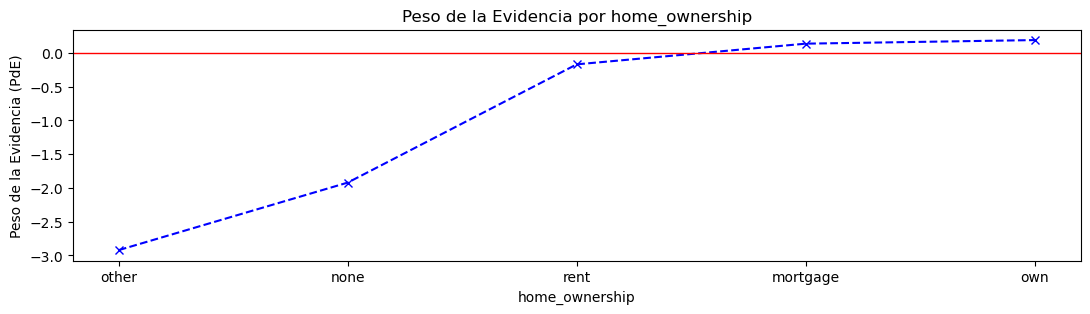

In [13]:
PdE = PdE_categorica(X_train, 'home_ownership', y_train)
display(PdE)
grafico_PdE(PdE)

In [14]:
X_train['home_rent_any_other_none'] = X_train[['home_rent', 'home_any', 'home_other', 'home_none']].sum(axis=1)

,addr_state,observaciones,proporcion_obs,PdE,VI,sumatoriaVI
0,ne,12,0.000029,-4.583954,0.009559,0.067773
1,ia,13,0.000031,-3.977818,0.005482,0.067773
2,mt,1247,0.002971,-0.864707,0.003515,0.067773
3,de,1136,0.002707,-0.599389,0.001328,0.067773
4,nv,5843,0.013923,-0.541763,0.005411,0.067773
5,mo,6761,0.016111,-0.365041,0.002587,0.067773
6,ky,3956,0.009427,-0.294510,0.000950,0.067773
7,pa,14793,0.035250,-0.274783,0.003060,0.067773
8,fl,28521,0.067963,-0.256877,0.005108,0.067773
9,ma,9991,0.023808,-0.215009,0.001227,0.067773


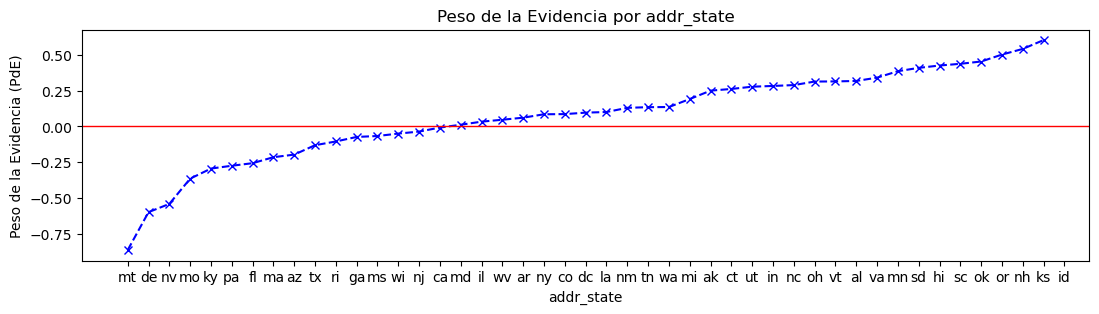

In [15]:
PdE = PdE_categorica(X_train, 'addr_state', y_train)
display(PdE)
grafico_PdE(PdE.iloc[2:-2,:]) # Se excluyen del grafico categorias con pocas observaciones

In [16]:
if ['addr_nd'] in X_train.columns.values:
    pass
else:
    X_train['addr_nd'] = 0

In [17]:
# Grupo 1 
X_train['addr_ne_ia_mt_de'] = (
    X_train['addr_ne'] + X_train['addr_ia'] +
    X_train['addr_mt'] + X_train['addr_de']
)
# Grupo 2 
X_train['addr_nv_mo_ky_pa'] = (
    X_train['addr_nv'] + X_train['addr_mo'] +
    X_train['addr_ky'] + X_train['addr_pa']
)
# Grupo 3 
X_train['addr_fl_ma_az_ri'] = (
    X_train['addr_fl'] + X_train['addr_ma'] +
    X_train['addr_az'] + X_train['addr_ri']
)
# Grupo 4 
X_train['addr_ga_ms_wi_nj'] = (
    X_train['addr_ga'] + X_train['addr_ms'] +
    X_train['addr_wi'] + X_train['addr_nj']
)
# Grupo 5 
X_train['addr_md_il_wv_ar'] = (
    X_train['addr_md'] + X_train['addr_il'] +
    X_train['addr_wv'] + X_train['addr_ar']
)
# Grupo 6 
X_train['addr_co_dc_la_nm'] = (
    X_train['addr_co'] + X_train['addr_dc'] +
    X_train['addr_la'] + X_train['addr_nm']
)
# Grupo 7 
X_train['addr_tn_wa_mi_ak'] = (
    X_train['addr_tn'] + X_train['addr_wa'] +
    X_train['addr_mi'] + X_train['addr_ak']
)
# Grupo 8 
X_train['addr_ct_ut_in_nc'] = (
    X_train['addr_ct'] + X_train['addr_ut'] +
    X_train['addr_in'] + X_train['addr_nc']
)
# Grupo 9 
X_train['addr_oh_vt_al_mn'] = (
    X_train['addr_oh'] + X_train['addr_vt'] +
    X_train['addr_al'] + X_train['addr_mn']
)
# Grupo 10 
X_train['addr_sd_hi_sc_ok'] = (
    X_train['addr_sd'] + X_train['addr_hi'] +
    X_train['addr_sc'] + X_train['addr_ok']
)
# Grupo 11 
X_train['addr_or_nh_ks_id'] = (
    X_train['addr_or'] + X_train['addr_nh'] +
    X_train['addr_ks'] + X_train['addr_id']
)
# Grupo 12 
X_train['addr_me_wy_nd'] = (
    X_train['addr_me'] + X_train['addr_wy'] + X_train['addr_nd']
)

,verification_status,observaciones,proporcion_obs,PdE,VI,sumatoriaVI
0,not verified,133324,0.317698,-0.343588,0.044692,0.078107
1,verified,151284,0.360495,0.123245,0.005154,0.078107
2,source verified,135048,0.321806,0.320208,0.028261,0.078107


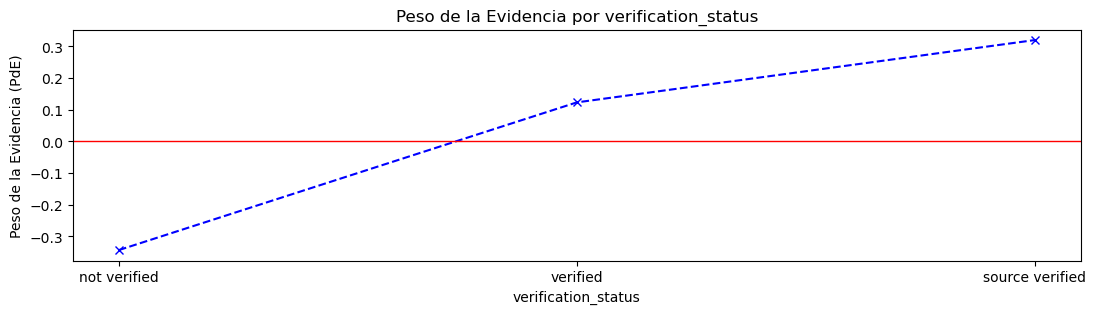

In [18]:
PdE = PdE_categorica(X_train, 'verification_status', y_train)
display(PdE)
grafico_PdE(PdE)

,purpose,observaciones,proporcion_obs,PdE,VI,sumatoriaVI
0,educational,385,0.000917,-3.174932,0.061956,0.214196
1,small_business,6326,0.015074,-1.286195,0.050331,0.214196
2,house,2065,0.004921,-0.891161,0.006275,0.214196
3,other,21337,0.050844,-0.725323,0.039149,0.214196
4,medical,4168,0.009932,-0.721653,0.007555,0.214196
5,moving,2683,0.006393,-0.684979,0.004294,0.214196
6,wedding,2118,0.005047,-0.595445,0.002439,0.214196
7,vacation,2265,0.005397,-0.158442,0.000147,0.214196
8,home_improvement,23871,0.056882,-0.094519,0.000533,0.214196
9,car,4854,0.011567,-0.031730,0.000012,0.214196


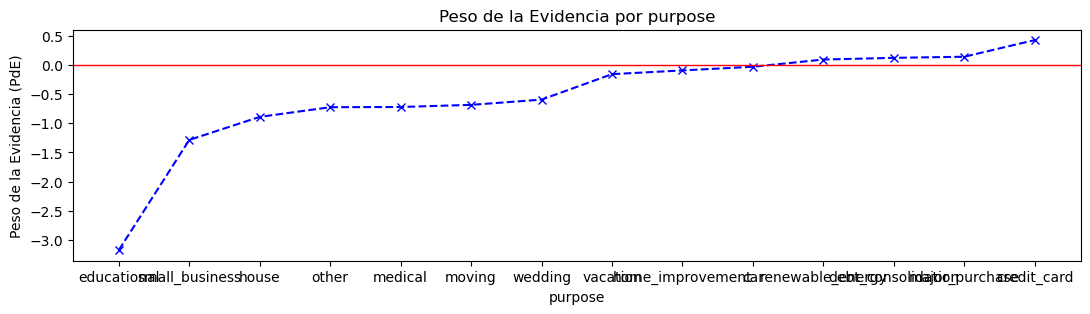

In [19]:
PdE = PdE_categorica(X_train, 'purpose', y_train)
display(PdE)
grafico_PdE(PdE)

In [20]:
# Grupo 1
X_train['purpose_educational_small_business'] = (
    X_train['purpose_educational'] + X_train['purpose_small_business']
)
# Grupo 2
X_train['purpose_house_moving_medical'] = (
    X_train['purpose_house'] + X_train['purpose_moving'] + X_train['purpose_medical']
)
# Grupo 3
X_train['purpose_wedding_vacation'] = (
    X_train['purpose_wedding'] + X_train['purpose_vacation']
)

,grade,observaciones,proporcion_obs,PdE,VI,sumatoriaVI
0,g,3000,0.007149,-2.123096,0.108940,0.65577
1,f,11912,0.028385,-1.051898,0.055279,0.65577
2,e,32114,0.076525,-0.870445,0.092020,0.65577
3,d,69267,0.165057,-0.447517,0.041612,0.65577
4,c,112753,0.268680,0.077947,0.001571,0.65577
5,b,123286,0.293779,0.686125,0.100243,0.65577
6,a,67324,0.160427,1.878838,0.256105,0.65577


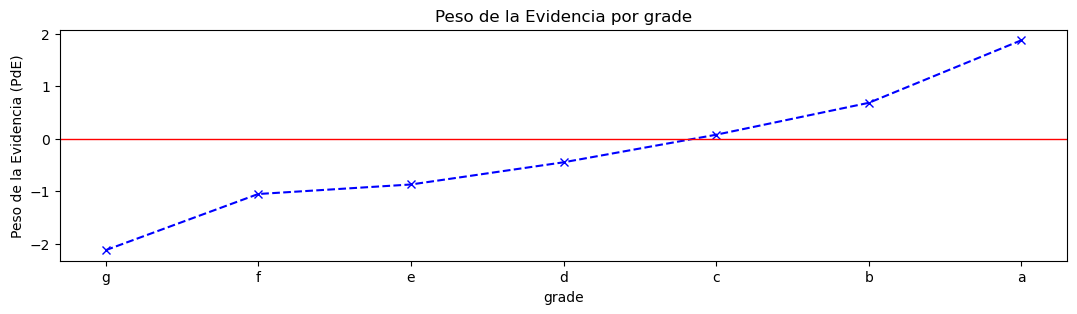

In [21]:
PdE = PdE_categorica(X_train, 'grade', y_train)
display(PdE)
grafico_PdE(PdE)

In [22]:
# Grupo 1
X_train['grade_g_f_e'] = X_train['grade_g'] + X_train['grade_f'] + X_train['grade_e']

# Grupo 2
X_train['grade_d_c'] = X_train['grade_d'] + X_train['grade_c']

,initial_list_status,observaciones,proporcion_obs,PdE,VI,sumatoriaVI
0,f,272685,0.649782,-0.162588,0.018641,0.064046
1,w,146971,0.350218,0.396024,0.045405,0.064046


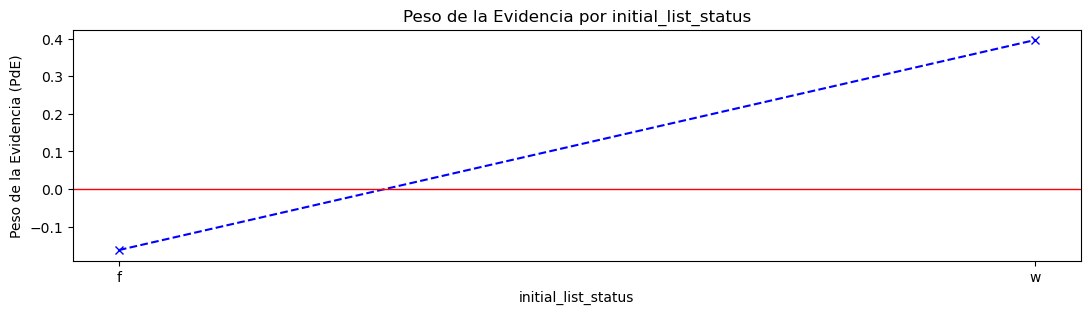

In [23]:
PdE = PdE_categorica(X_train, 'initial_list_status', y_train)
display(PdE)
grafico_PdE(PdE)

### PESO DE LA EVIDENCIA (PdE) Y VALOR DE LA INFORMACIÓN (VI) - VARIABLES NO CATEGORICAS

In [24]:
columns = X_train.select_dtypes([ 'int64']).columns
uniques = {}

for col in columns:
    u = list(X_train[col].unique())
    uniques[col] = len(u)

pd.Series(uniques).sort_values(ascending=True).head(20)

policy_code         1
addr_nd             1
term                2
emp_length         11
loan_amnt        1349
funded_amnt      1351
revol_bal       56460
id             419656
member_id      419656
dtype: int64

In [25]:
def PdE_continua(df, var_categorica, df_var_dependiente):
    df = pd.concat([df[var_categorica], df_var_dependiente], axis = 1)
    df = pd.concat([
    df.groupby(df.columns.values[0], as_index=False, observed=False)[df.columns.values[1]].count(),
    df.groupby(df.columns.values[0], as_index=False, observed=False)[df.columns.values[1]].mean()
    ], axis=1)

    df = df.iloc[:, [0,1,3]]
    df.columns = [df.columns.values[0], 'observaciones', 'prop_bueno']

    
    df['proporcion_obs'] = df['observaciones']/df['observaciones'].sum()
    df['n_buenos'] = df['prop_bueno']*df['observaciones']
    df['n_malos'] = (1- df['prop_bueno'])*df['observaciones'] 
    df['prop_n_buenos'] = df['n_buenos']/df['n_buenos'].sum()
    df['prop_n_malos'] = df['n_malos']/df['n_malos'].sum() 
    df['PdE'] = np.log(df['prop_n_buenos']/df['prop_n_malos'])

    
    df['delta_prop_n_buenos'] = df['prop_n_buenos'].diff().abs() 
    df['delta_PdE'] = df['PdE'].diff().abs() #Diferencia Absoluta entre categorías
    df['VI'] = (df['prop_n_buenos'] - df['prop_n_malos']) * df['PdE']
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df['sumatoriaVI'] = df['VI'].sum()
    
    return df[[var_categorica, 'observaciones', 'proporcion_obs', 'PdE', 'VI', 'sumatoriaVI']].sort_values(by=var_categorica, ascending=True)

,term,observaciones,proporcion_obs,PdE,VI,sumatoriaVI
0,36,304125,0.724701,0.009745,0.000068,0.000246
1,60,115531,0.275299,-0.025210,0.000177,0.000246


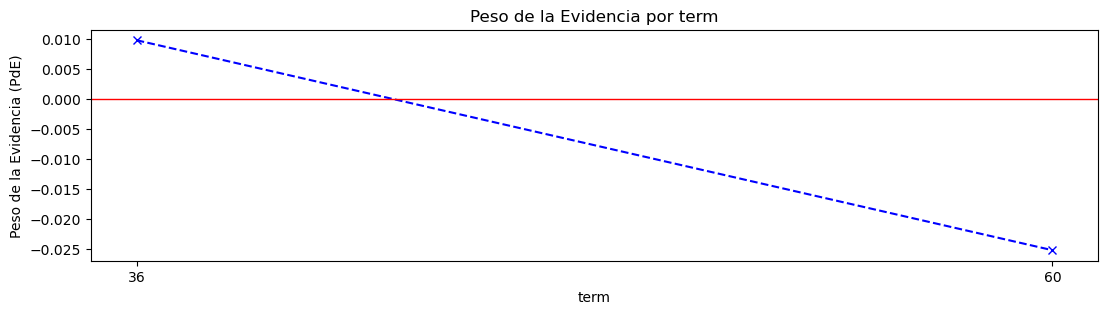

In [26]:
PdE = PdE_continua(X_train, 'term', y_train)
display(PdE)
grafico_PdE(PdE)

In [27]:
X_train['term_36'] = X_train.term.apply(lambda x: 1 if x == 36 else 0)
X_train['term_60'] = X_train.term.apply(lambda x: 1 if x == 60 else 0)

,emp_length,observaciones,proporcion_obs,PdE,VI,sumatoriaVI
0,0,51671,0.123127,-0.147057,2.866918e-03,0.034653
1,1,26660,0.063528,-0.452815,1.644355e-02,0.034653
2,2,37209,0.088665,-0.029295,7.720960e-05,0.034653
3,3,32961,0.078543,-0.078954,5.093272e-04,0.034653
4,4,25283,0.060247,-0.036842,8.328831e-05,0.034653
5,5,27681,0.065961,0.065414,2.732733e-04,0.034653
6,6,23514,0.056032,-0.002650,3.939663e-07,0.034653
7,7,23570,0.056165,0.105438,5.928071e-04,0.034653
8,8,20109,0.047918,-0.134239,9.236729e-04,0.034653
9,9,16060,0.038269,0.127326,5.827856e-04,0.034653


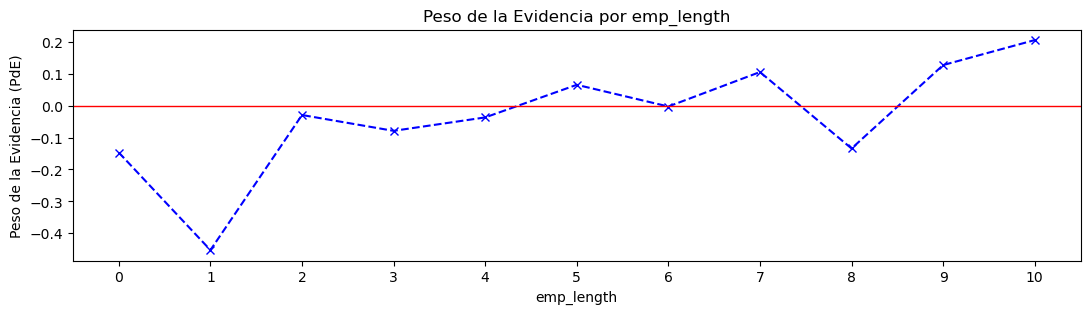

In [28]:
PdE = PdE_continua(X_train, 'emp_length', y_train)
display(PdE)
grafico_PdE(PdE)

In [29]:
X_train['emp_length_0'] = X_train.emp_length.apply(lambda x: 1 if x == 0 else 0)
X_train['emp_length_1'] = X_train.emp_length.apply(lambda x: 1 if x == 1 else 0)
X_train['emp_length_2a7'] = np.where(X_train.emp_length.isin(range(2,8)), 1, 0)
X_train['emp_length_8'] = X_train.emp_length.apply(lambda x: 1 if x == 8 else 0)
X_train['emp_length_9'] = X_train.emp_length.apply(lambda x: 1 if x == 9 else 0)
X_train['emp_length_10'] = X_train.emp_length.apply(lambda x: 1 if x == 10 else 0)

In [30]:
X_train['linea_mesescredito_bins'] = pd.cut(X_train.linea_mesescredito, 50)

,linea_mesescredito_bins,observaciones,proporcion_obs,PdE,VI,sumatoriaVI
0,"(-0.924, 18.479]",25,0.000060,-3.240219,4.372679e-03,0.033389
1,"(18.479, 36.958]",0,0.000000,NaN,NaN,0.033389
2,"(36.958, 55.437]",0,0.000000,NaN,NaN,0.033389
3,"(55.437, 73.916]",0,0.000000,NaN,NaN,0.033389
4,"(73.916, 92.395]",0,0.000000,NaN,NaN,0.033389
5,"(92.395, 110.874]",3,0.000007,NaN,NaN,0.033389
6,"(110.874, 129.353]",2821,0.006722,0.061860,2.494922e-05,0.033389
7,"(129.353, 147.832]",5105,0.012165,0.079681,7.425771e-05,0.033389
8,"(147.832, 166.311]",14415,0.034350,-0.001767,1.073683e-07,0.033389
9,"(166.311, 184.79]",22008,0.052443,-0.407006,1.070343e-02,0.033389


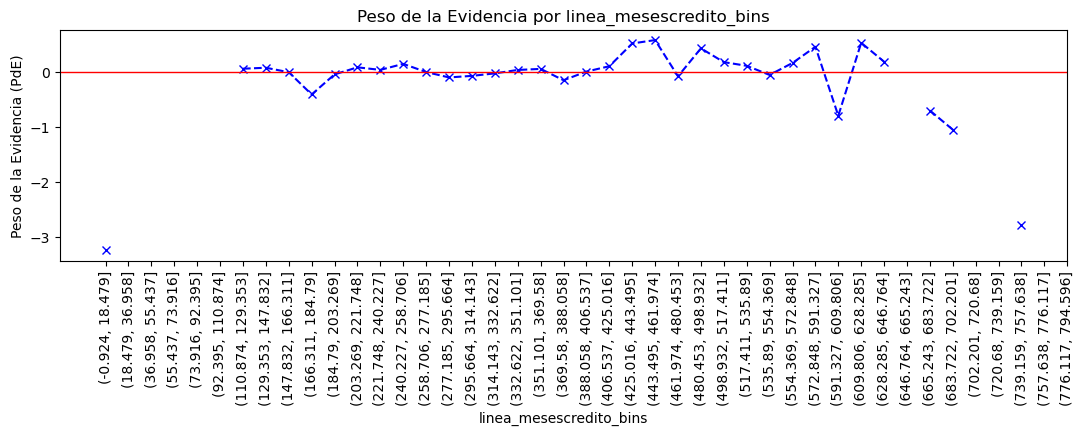

In [31]:
PdE = PdE_continua(X_train, 'linea_mesescredito_bins', y_train)
display(PdE)
grafico_PdE(PdE)
plt.xticks(rotation=90)
plt.show()

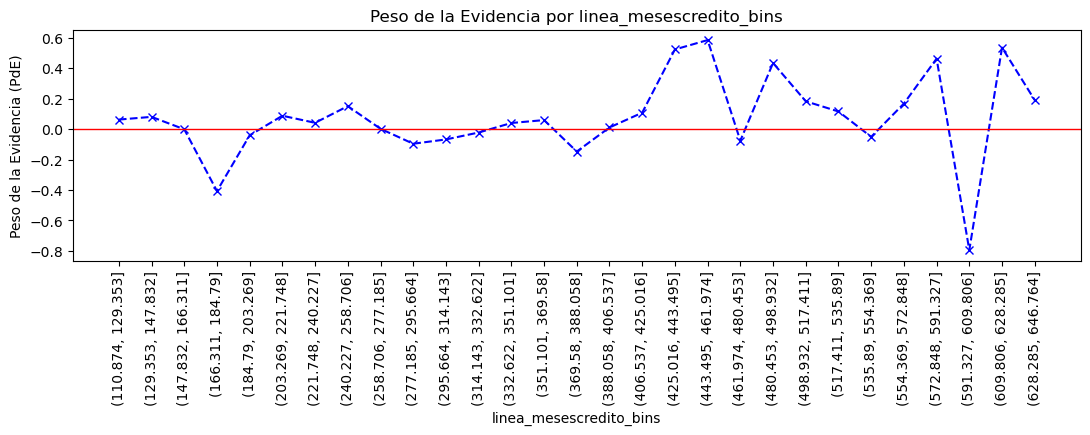

In [32]:
grafico_PdE(PdE.iloc[6:-15])
plt.xticks(rotation=90)
plt.show()

In [33]:
# Grupo de baja proporcion de observaciones
X_train['meses_credito_0_110'] = X_train.linea_mesescredito.apply(lambda x: 1 if x <= 110 else 0)

###########################################
X_train['meses_credito_110_129'] = X_train.linea_mesescredito.apply(lambda x: 1 if 110 < x <= 129 else 0)
X_train['meses_credito_129_166'] = X_train.linea_mesescredito.apply(lambda x: 1 if 129 < x <= 166 else 0)
X_train['meses_credito_166_184'] = X_train.linea_mesescredito.apply(lambda x: 1 if 166 < x <= 184 else 0)
X_train['meses_credito_184_240'] = X_train.linea_mesescredito.apply(lambda x: 1 if 184 < x <= 240 else 0)
X_train['meses_credito_240_258'] = X_train.linea_mesescredito.apply(lambda x: 1 if 240 < x <= 258 else 0)
X_train['meses_credito_258_406'] = X_train.linea_mesescredito.apply(lambda x: 1 if 258 < x <= 406 else 0)
X_train['meses_credito_406_425'] = X_train.linea_mesescredito.apply(lambda x: 1 if 406 < x <= 425 else 0)
X_train['meses_credito_425_443'] = X_train.linea_mesescredito.apply(lambda x: 1 if 425 < x <= 443 else 0)
X_train['meses_credito_443_461'] = X_train.linea_mesescredito.apply(lambda x: 1 if 443 < x <= 461 else 0)

# Grupo de baja proporcion de observaciones
X_train['meses_credito_461_plus'] = X_train.linea_mesescredito.apply(lambda x: 1 if 461 < x  else 0)

### PESO DE LA EVIDENCIA (PdE) Y VALOR DE LA INFORMACIÓN (VI) - VARIABLES CONTINUAS

In [34]:
X_train['annual_inc_bins'] = pd.cut(X_train.annual_inc, 100)

In [35]:
PdE = PdE_continua(X_train, 'annual_inc_bins', y_train)
display(PdE)

,annual_inc_bins,observaciones,proporcion_obs,PdE,VI,sumatoriaVI
0,"(-5602.104, 76877.04]",275903,0.657450,-0.117984,0.009710,0.049007
1,"(76877.04, 151858.08]",125367,0.298738,0.346920,0.030411,0.049007
2,"(151858.08, 226839.12]",13342,0.031793,-0.015989,0.000008,0.049007
3,"(226839.12, 301820.16]",3200,0.007625,-0.012999,0.000001,0.049007
4,"(301820.16, 376801.2]",792,0.001887,-1.323297,0.006819,0.049007
...,...,...,...,...,...,...
95,"(7125094.8, 7200075.84]",1,0.000002,NaN,NaN,0.049007
96,"(7200075.84, 7275056.88]",0,0.000000,NaN,NaN,0.049007
97,"(7275056.88, 7350037.92]",0,0.000000,NaN,NaN,0.049007
98,"(7350037.92, 7425018.96]",0,0.000000,NaN,NaN,0.049007


In [36]:
df_temp = X_train.copy()
df_temp = df_temp[X_train.annual_inc <= 152000]
df_temp['annual_inc_bins'] = pd.cut(df_temp.annual_inc, 50)

,annual_inc_bins,observaciones,proporcion_obs,PdE,VI,sumatoriaVI
0,"(1745.896, 4898.08]",18,0.000045,-3.608384,0.005182,0.14137
1,"(4898.08, 7900.16]",49,0.000122,-3.267457,0.009278,0.14137
2,"(7900.16, 10902.24]",416,0.001036,-0.355107,0.000157,0.14137
3,"(10902.24, 13904.32]",794,0.001978,-1.326002,0.007187,0.14137
4,"(13904.32, 16906.4]",1654,0.004120,-1.059183,0.008170,0.14137
5,"(16906.4, 19908.48]",2082,0.005187,-1.052126,0.010107,0.14137
6,"(19908.48, 22910.56]",4130,0.010288,-0.736135,0.008209,0.14137
7,"(22910.56, 25912.64]",7165,0.017849,-0.479882,0.005264,0.14137
8,"(25912.64, 28914.72]",6767,0.016858,-0.587662,0.007902,0.14137
9,"(28914.72, 31916.8]",11420,0.028449,-0.570184,0.012435,0.14137


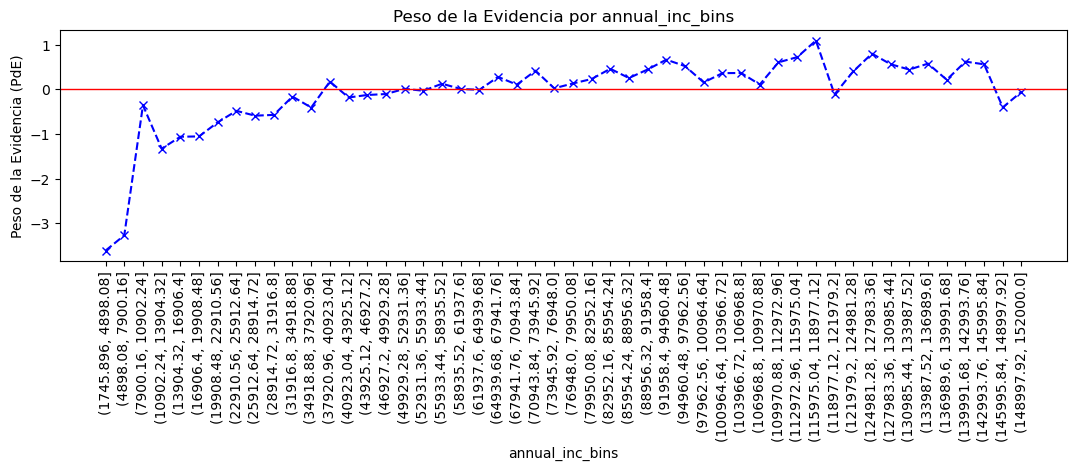

In [37]:
PdE = PdE_continua(df_temp, 'annual_inc_bins', y_train)
display(PdE)
grafico_PdE(PdE)
plt.xticks(rotation=90)
plt.show()

In [38]:
# Grupo de baja proporcion de observaciones
X_train['annual_inc_0_20k'] = X_train.annual_inc.apply(lambda x: 1 if x <= 20000 else 0)

# Grupos con ingresos en la media
X_train['annual_inc_20k_30k'] = X_train.annual_inc.apply(lambda x: 1 if 20000 < x <= 30000 else 0)
X_train['annual_inc_30k_40k'] = X_train.annual_inc.apply(lambda x: 1 if 30000 < x <= 40000 else 0)
X_train['annual_inc_40k_50k'] = X_train.annual_inc.apply(lambda x: 1 if 40000 < x <= 50000 else 0)
X_train['annual_inc_50k_60k'] = X_train.annual_inc.apply(lambda x: 1 if 50000 < x <= 60000 else 0)
X_train['annual_inc_60_70k'] = X_train.annual_inc.apply(lambda x: 1 if 60000 < x <= 70000 else 0)
X_train['annual_inc_70_80k'] = X_train.annual_inc.apply(lambda x: 1 if 70000 < x <= 80000 else 0)
X_train['annual_inc_80_90k'] = X_train.annual_inc.apply(lambda x: 1 if 80000 < x <= 90000 else 0)
X_train['annual_inc_90_100k'] = X_train.annual_inc.apply(lambda x: 1 if 90000 < x <= 100000 else 0)
X_train['annual_inc_100_126k'] = X_train.annual_inc.apply(lambda x: 1 if 100000 < x <= 126000 else 0)
X_train['annual_inc_126k_152k'] = X_train.annual_inc.apply(lambda x: 1 if 126000 < x <= 152000 else 0)

# Grupos con ingresos por encima de la media
X_train['annual_inc_152_227k'] = X_train.annual_inc.apply(lambda x: 1 if 152000 < x <= 227000 else 0)
X_train['annual_inc_227k_plus'] = X_train.annual_inc.apply(lambda x: 1 if 227000 < x  else 0)

In [39]:
df_temp = X_train.copy()
df_temp = df_temp[pd.notnull(X_train.mths_since_last_delinq)]
df_temp['mnths_since_last_delinq_bins'] = pd.cut(df_temp.mths_since_last_delinq, 50)

,mnths_since_last_delinq_bins,observaciones,proporcion_obs,PdE,VI,sumatoriaVI
0,"(-0.188, 3.76]",5950,0.030630,-1.823861,0.284241,0.353653
1,"(3.76, 7.52]",12435,0.064013,0.053643,0.000179,0.353653
2,"(7.52, 11.28]",14984,0.077135,0.179944,0.002287,0.353653
3,"(11.28, 15.04]",14940,0.076908,0.420678,0.011126,0.353653
4,"(15.04, 18.8]",10446,0.053774,0.139949,0.000983,0.353653
5,"(18.8, 22.56]",13104,0.067457,0.085547,0.000473,0.353653
6,"(22.56, 26.32]",12306,0.063349,0.548628,0.014701,0.353653
7,"(26.32, 30.08]",11890,0.061208,0.142686,0.001162,0.353653
8,"(30.08, 33.84]",8536,0.043942,0.082997,0.000291,0.353653
9,"(33.84, 37.6]",10982,0.056533,0.016250,0.000015,0.353653


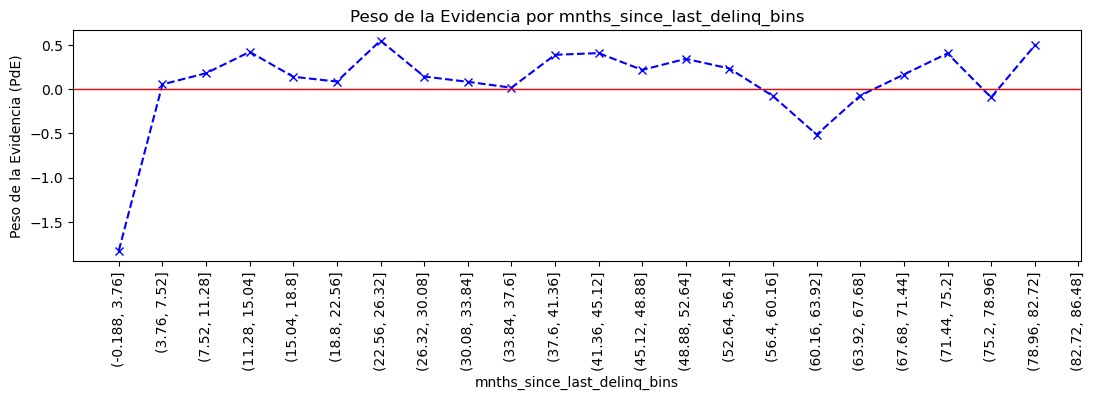

In [40]:
PdE = PdE_continua(df_temp, 'mnths_since_last_delinq_bins', y_train[df_temp.index])
display(PdE)
grafico_PdE(PdE)
plt.xticks(rotation=90)
plt.show()

In [41]:
X_train['mnths_since_last_delinq_null'] = np.where((X_train['mths_since_last_delinq'].isnull()), 1, 0)
X_train['mnths_since_last_delinq_0a4'] = X_train.mths_since_last_delinq.apply(lambda x: 1 if x <= 4 else 0)
X_train['mnths_since_last_delinq_4a23'] = X_train.mths_since_last_delinq.apply(lambda x: 1 if 4 < x <= 23 else 0)
X_train['mnths_since_last_delinq_23a56'] = X_train.mths_since_last_delinq.apply(lambda x: 1 if 23 < x <= 56 else 0)
X_train['mnths_since_last_delinq_56a64'] = X_train.mths_since_last_delinq.apply(lambda x: 1 if 56 < x <= 64 else 0)
X_train['mnths_since_last_delinq_64a83'] = X_train.mths_since_last_delinq.apply(lambda x: 1 if 64 < x <= 83 else 0)
X_train['mnths_since_last_delinq_83_plus'] = X_train.mths_since_last_delinq.apply(lambda x: 1 if 83 < x  else 0)

,delinq_2yrs,observaciones,proporcion_obs,PdE,VI,sumatoriaVI
0,0.0,344728,0.821454,0.004945,0.000020,0.004181
1,1.0,50548,0.120451,0.032835,0.000128,0.004181
2,2.0,14666,0.034948,-0.136225,0.000694,0.004181
3,3.0,5116,0.012191,-0.090598,0.000105,0.004181
4,4.0,2151,0.005126,-0.092046,0.000045,0.004181
5,5.0,1119,0.002666,0.642688,0.000814,0.004181
6,6.0,575,0.001370,-0.432040,0.000319,0.004181
7,7.0,315,0.000751,-0.629510,0.000413,0.004181
8,8.0,155,0.000369,-0.645614,0.000216,0.004181
9,9.0,101,0.000241,-1.077396,0.000499,0.004181


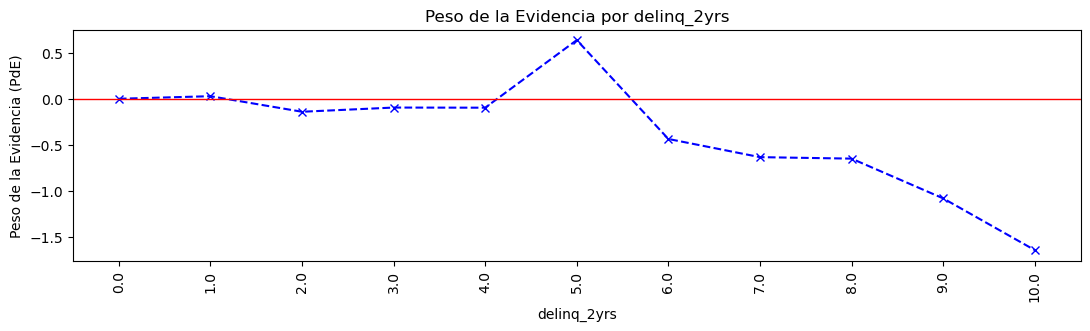

In [42]:
PdE = PdE_continua(X_train, 'delinq_2yrs', y_train)
display(PdE)
grafico_PdE(PdE)
plt.xticks(rotation=90)
plt.show()

In [43]:
X_train['delinq_2yrs_0'] = X_train.delinq_2yrs.apply(lambda x: 1 if x == 0 else 0)
X_train['delinq_2yrs_1a4'] = X_train.delinq_2yrs.apply(lambda x: 1 if 1 <= x <= 4 else 0)
X_train['delinq_2yrs_5_plus'] = X_train.delinq_2yrs.apply(lambda x: 1 if x >= 5 else 0)

,total_acc_bins,observaciones,proporcion_obs,PdE,VI,sumatoriaVI
0,"(-0.156, 3.12]",516,0.001230,-2.932405,6.043692e-02,0.144046
1,"(3.12, 6.24]",6763,0.016116,-1.092958,3.469589e-02,0.144046
2,"(6.24, 9.36]",16957,0.040407,-0.471359,1.144566e-02,0.144046
3,"(9.36, 12.48]",28247,0.067310,-0.001577,1.674249e-07,0.144046
4,"(12.48, 15.6]",37867,0.090233,-0.162007,2.569379e-03,0.144046
5,"(15.6, 18.72]",43601,0.103897,0.218412,4.455351e-03,0.144046
6,"(18.72, 21.84]",45796,0.109127,0.234512,5.353559e-03,0.144046
7,"(21.84, 24.96]",45116,0.107507,0.235950,5.335274e-03,0.144046
8,"(24.96, 28.08]",53277,0.126954,0.103879,1.301627e-03,0.144046
9,"(28.08, 31.2]",33461,0.079734,0.314245,6.762827e-03,0.144046


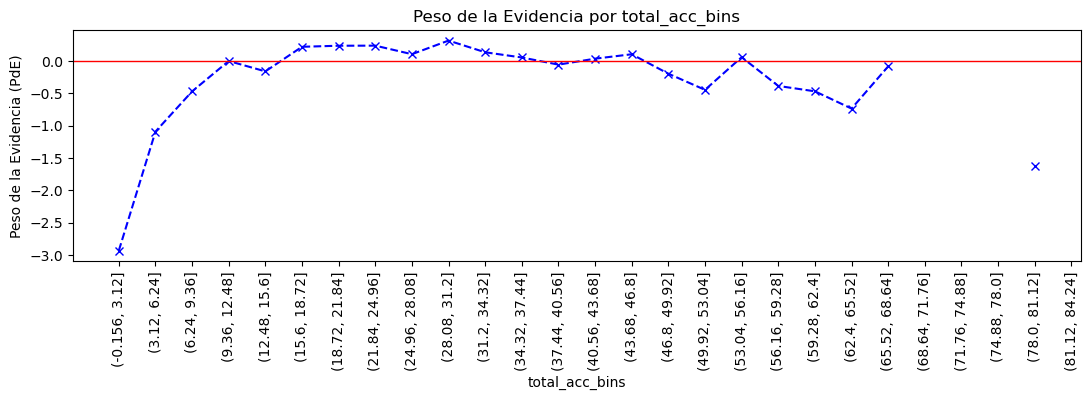

In [44]:
X_train['total_acc_bins'] = pd.cut(X_train.total_acc, 50)

PdE = PdE_continua(X_train, 'total_acc_bins', y_train)
display(PdE)
grafico_PdE(PdE)
plt.xticks(rotation=90)
plt.show()

In [45]:
X_train['total_acc_0a6'] = X_train.total_acc.apply(lambda x: 1 if x <= 6 else 0)
X_train['total_acc_6a25'] = X_train.total_acc.apply(lambda x: 1 if 6 < x <= 25 else 0)
X_train['total_acc_25a50'] = X_train.total_acc.apply(lambda x: 1 if 25 < x <= 50 else 0)
X_train['total_acc_50_plus'] = X_train.total_acc.apply(lambda x: 1 if 50 < x  else 0)

,dti_bins,observaciones,proporcion_obs,PdE,VI,sumatoriaVI
0,"(-0.04, 0.8]",1752,0.004175,-1.169396,1.075735e-02,0.04796
1,"(0.8, 1.6]",2211,0.005269,-0.822298,5.503074e-03,0.04796
2,"(1.6, 2.399]",2830,0.006744,-0.512793,2.311482e-03,0.04796
3,"(2.399, 3.199]",3657,0.008714,-0.575245,3.887554e-03,0.04796
4,"(3.199, 3.999]",4607,0.010978,-0.296325,1.120698e-03,0.04796
5,"(3.999, 4.799]",5666,0.013502,0.184256,4.188671e-04,0.04796
6,"(4.799, 5.599]",6751,0.016087,-0.087706,1.292965e-04,0.04796
7,"(5.599, 6.398]",7666,0.018267,0.039841,2.843024e-05,0.04796
8,"(6.398, 7.198]",8691,0.020710,0.126384,3.108721e-04,0.04796
9,"(7.198, 7.998]",9897,0.023584,0.256693,1.371591e-03,0.04796


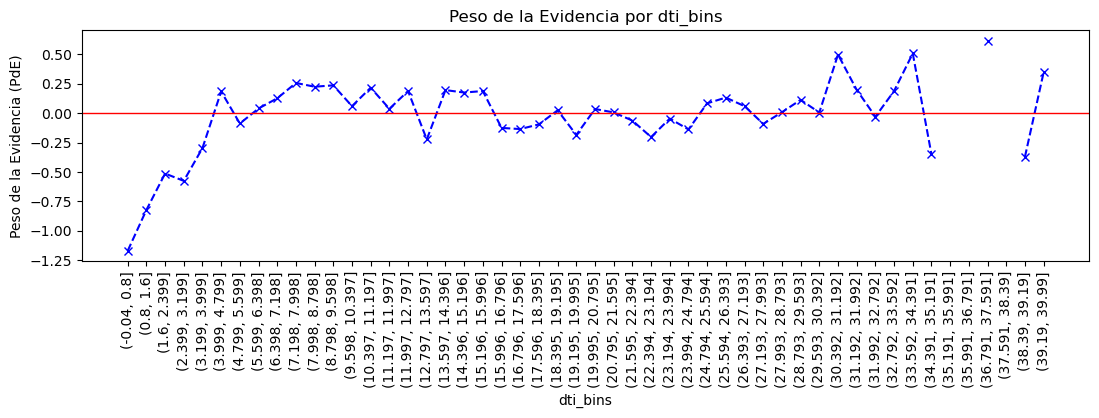

In [46]:
X_train['dti_bins'] = pd.cut(X_train.dti, 50)

PdE = PdE_continua(X_train, 'dti_bins', y_train)
display(PdE)
grafico_PdE(PdE)
plt.xticks(rotation=90)
plt.show()

In [47]:
X_train['dti_0a4'] = X_train.dti.apply(lambda x: 1 if x <= 4 else 0)
X_train['dti_4a13'] = X_train.dti.apply(lambda x: 1 if 4 < x <= 13 else 0)
X_train['dti_13a31'] = X_train.dti.apply(lambda x: 1 if 13 < x <= 31 else 0)
X_train['dti_31_plus'] = X_train.dti.apply(lambda x: 1 if 31 < x else 0)

In [48]:
df_temp = X_train.copy()
df_temp = df_temp[pd.notnull(X_train.mths_since_last_record)]
df_temp['mths_since_last_record_bins'] = pd.cut(df_temp.mths_since_last_record, 50)

,mths_since_last_record_bins,observaciones,proporcion_obs,PdE,VI,sumatoriaVI
0,"(-0.129, 2.58]",1180,0.020979,-3.310232,1.560397,1.991173
1,"(2.58, 5.16]",140,0.002489,NaN,NaN,1.991173
2,"(5.16, 7.74]",144,0.002560,-0.749299,0.002124,1.991173
3,"(7.74, 10.32]",282,0.005014,NaN,NaN,1.991173
4,"(10.32, 12.9]",226,0.004018,0.404122,0.000541,1.991173
5,"(12.9, 15.48]",357,0.006347,0.862952,0.003178,1.991173
6,"(15.48, 18.06]",379,0.006738,0.227120,0.000311,1.991173
7,"(18.06, 20.64]",271,0.004818,0.586443,0.001257,1.991173
8,"(20.64, 23.22]",507,0.009014,1.214558,0.007734,1.991173
9,"(23.22, 25.8]",360,0.006400,0.871344,0.003256,1.991173


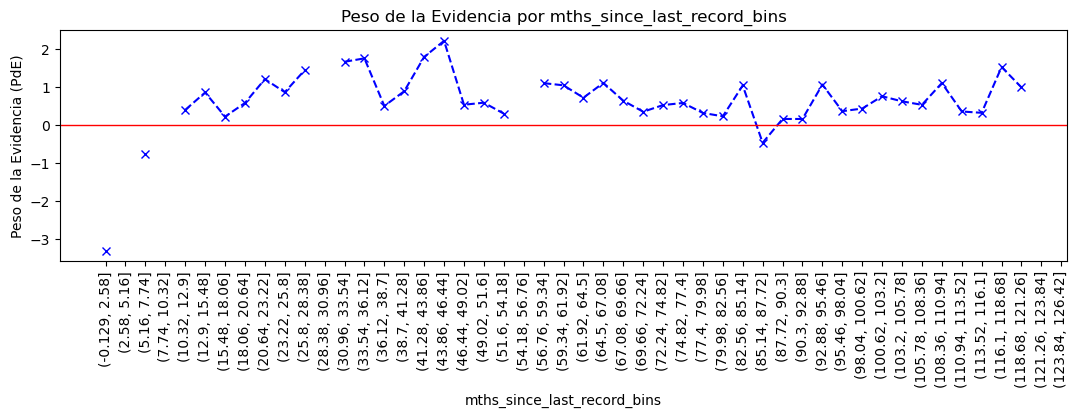

In [49]:
PdE = PdE_continua(df_temp, 'mths_since_last_record_bins', y_train[df_temp.index])
display(PdE)
grafico_PdE(PdE)
plt.xticks(rotation=90)
plt.show()

In [50]:
X_train['mths_since_last_record_null'] = np.where((X_train['mths_since_last_record'].isnull()), 1, 0)
X_train['mths_since_last_record_0a3'] = X_train.mths_since_last_record.apply(lambda x: 1 if x <= 3 else 0)
X_train['mths_since_last_record_3a26'] = X_train.mths_since_last_record.apply(lambda x: 1 if 3 < x <= 26 else 0)
X_train['mths_since_last_record_26a57'] = X_train.mths_since_last_record.apply(lambda x: 1 if 26 < x <= 57 else 0)
X_train['mths_since_last_record_57a88'] = X_train.mths_since_last_record.apply(lambda x: 1 if 57 < x <= 88 else 0)
X_train['mths_since_last_record_88a119'] = X_train.mths_since_last_record.apply(lambda x: 1 if 88 < x <= 119 else 0)
X_train['mths_since_last_record_119_plus'] = X_train.mths_since_last_record.apply(lambda x: 1 if 119 < x else 0)

In [51]:
X_train.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'dti_4a13', 'dti_13a31', 'dti_31_plus', 'mths_since_last_record_null',
       'mths_since_last_record_0a3', 'mths_since_last_record_3a26',
       'mths_since_last_record_26a57', 'mths_since_last_record_57a88',
       'mths_since_last_record_88a119', 'mths_since_last_record_119_plus'],
      dtype='object', length=282)

In [52]:
#X_test = X_train
#y_test = y_train

In [53]:
#X_train.to_csv(PROCESSED_DATA_PATH / 'X_train.csv', index=False)
#y_train.to_csv(PROCESSED_DATA_PATH / 'y_train.csv', index=False)

In [54]:
#X_test.to_csv(PROCESSED_DATA_PATH / 'X_test.csv', index=False)
#y_test.to_csv(PROCESSED_DATA_PATH / 'y_test.csv', index=False)